# Main programme avec interaction avec l'utilisateur



L'idée de ce dossier est de modéliser un CP avec interaction d'un décision-maker.

In [22]:
#############################
### Import libraries ###
#############################

from docplex.cp.model import *
from docplex.cp.config import get_default
import numpy as np
from Solver import *
from User import *
import time

In [23]:
#############################
### Main program ###
#############################

print("\n--------Main program is loading...---------")

# Parameters

k = 20

# Interaction with the solver

data = []
file = './example.data'
optimalval = -1

with open(file, 'r') as f:    
    for line in f:
        if line.startswith('optimalval ='):
            line_splitted = line.strip().split('=')
            optimalval = int(line_splitted[1])
        else:
            data.append(line.strip().split())

n = int(data[0][0])
m = int(data[0][1])

T_machine = []
T_duration = []

for i in range(1,n+1):
    for j in range(0, 2*m, 2):
        T_machine.append(int(data[i][j]))
        T_duration.append(int(data[i][j+1]))

duration = np.zeros((n, m))

for i in range(n):
    for j in range(m):
        ind_machine = int(T_machine[i*m + j])
        duration[i][ind_machine] = T_duration[i*m + j]


# --------- Call Solver constructor in Solver.py

solver = Solver(data)

model = CpoModel() 

# --------- Create the model variables 

solver.create_variables(model, n, m, duration)

# ------------ Solve the model

print("\nSolving the model...")
msol, nb_solution, runtime = solver.solve(model, k, n, m, T_machine, optimalval)

# ------------ Display the result

for sol in msol:
    sol.write()
print("Model solved !")


# ---------------- Interaction with the user

print("\n--------Interaction with the user...---------")

print("\nCreating the user...")
user = User()
print("User created !")

print("\nClassing solutions...")	
list_indice, list_equal = user.classerSolutions(msol)
print("Solutions classed !")

print("\nCreating preferences...")
pref = user.getPreferences()
print("Preferences created !")

print("\nDisplaying preferences...")
# for sol in pref:
#     sol.write()

# print("\nPreferences : ", pref)
# print(list_indice)
# print(list_equal)

variables = solver.get_variables()
matrix = user.matrix_pref(n, m, False)

pref = user.getPreferences()

print("\nTesting preferences...")

if user.test_preferences(pref):
    print("\tL'ordre des préférences est cohérente")
else:
    print("\tL'ordre des préférences n'est pas cohérente")
    
if user.test_differences_sol(matrix):
    print("\tToutes les solutions sont différentes")
else:
    print("\tLes solutions ne sont pas toutes différentes")



--------Main program is loading...---------

Solver initialized !

Creating the model variables...
Model variables created !

Solving the model...

Adding precedence constraints to the solver...
Precedence constraints added !

Adding disjunctive constraints to the solver...
Disjunctive constraints added !
-------------------------------------------------------------------------------
Model constraints: 37, variables: integer: 0, interval: 36, sequence: 6
Solve status: Feasible
Search status: SearchOngoing, stop cause: SearchHasNotBeenStopped
Solve time: 0.02 sec
-------------------------------------------------------------------------------
Variables:
   T0-0 = IntervalVarValue(start=6, end=9, size=3)
   T0-1 = IntervalVarValue(start=16, end=22, size=6)
   T0-2 = IntervalVarValue(start=5, end=6, size=1)
   T0-3 = IntervalVarValue(start=22, end=29, size=7)
   T0-4 = IntervalVarValue(start=54, end=60, size=6)
   T0-5 = IntervalVarValue(start=29, end=32, size=3)
   T1-0 = IntervalVarValu

In [24]:
###  -------------- Iteration of the solver with the preferences

# ----------------- Parameters

tps_max = 100
tps = runtime
it_max = 5
it = 1
k_k = 3

criterion = (tps < tps_max) and (it < it_max) 

# ----------------- Add the preferences to the model

while criterion :

    it += 1
    
    solver = Solver(data)
    model = CpoModel() 

    # --------- Create the model variables 

    solver.create_variables(model, n, m, duration) 

    # stop = int(input("Do you want to continue ? True(1) or False(0)"))

    bb = integer_var(0,1)
    solver.add_variable(bb)
    bb=1

    list_variables = solver.get_variables()
    variables = list_variables[0]

    for sol in pref:
        b = integer_var(0,1)
        solver.add_variable(b)
        b=0

        for i in range(n):
            for j in range(m):

                var_sol = sol.get_value("T{}-{}".format(i,j))
                #a = model.interval_var(start = sol[variables[i][j]].start, end= sol[variables[i][j]].end, size=int(duration[i][j]), name="a{}{}".format(i,j))
                #b =max(b,logical_or((model.start_of(a) != model.start_of(variables[i][j])), (model.end_of(a) != model.end_of(variables[i][j]))))
                
                b =max(b,logical_or(var_sol.start != model.start_of(variables[i][j]), var_sol.end != model.end_of(variables[i][j])))
        b = (b!=0)
        bb = bb * b
    solver.add_constraint(bb==1)
    

# ------------ Solve the model

    print("\nSolving the model...")

    msol, nb_solution, runtime = solver.solve(model, k_k, n, m, T_machine, optimalval)

# ------------ Display the result

    # for sol in msol:
    #     sol.write()
    print("Model solved !")


# ---------------- Interaction with the user

    print("\n--------Interaction with the user...---------")

    print("\nClassing solutions...")	
    list_indice, list_equal = user.classerSolutions(msol)
    # print(list_indice)
    print("Solutions classed !")

    print("\nCreating preferences...")
    pref = user.getPreferences()
    print("Preferences created !")

    print("\nDisplaying preferences...")
    # for sol in pref:
    #     sol.write()

    # print("\nPreferences : ", pref)
    # print(list_indice)
    # print(list_equal)
    # print(len(pref))

    starts = user.start_pref(n, m, variables, True)

    matrix = user.matrix_pref(n, m, False)
    print(len(matrix))
    print("\nTesting preferences...")

    pref = user.getPreferences()
    
    if user.test_preferences(pref):
        print("\tL'ordre des préférences est cohérente")
    else:
        print("\tL'ordre des préférences n'est pas cohérente")
        
    if user.test_differences_sol(matrix):
        print("\tToutes les solutions sont différentes")
    else:
        print("\tLes solutions ne sont pas toutes différentes")

    tps += runtime

    criterion = (tps < tps_max) and (it < it_max)

    if (it == it_max):
        print("The user has reached the maximum number of iterations !")
    # elif not stop:
    #     print("The user has chosen his/her solution !")
    elif (tps >= tps_max):
        print("The user has reached the maximum time !")


print("\n--------End of the interaction with the user...---------")


Solver initialized !

Creating the model variables...
Model variables created !

Solving the model...

Adding precedence constraints to the solver...
Precedence constraints added !

Adding disjunctive constraints to the solver...
Disjunctive constraints added !
Model solved !

--------Interaction with the user...---------

Classing solutions...
Solutions classed !

Creating preferences...
Preferences created !

Displaying preferences...
[6, 16, 5, 22, 54, 29, 42, 0, 15, 52, 20, 32, 18, 27, 0, 5, 47, 9, 13, 8, 20, 29, 35, 46, 52, 22, 6, 56, 30, 42, 28, 13, 47, 16, 43, 19]
[6, 16, 5, 22, 54, 29, 42, 0, 15, 56, 20, 32, 18, 27, 0, 5, 47, 9, 13, 8, 20, 29, 35, 46, 52, 22, 6, 55, 30, 42, 28, 13, 47, 16, 43, 19]
[6, 16, 5, 22, 47, 29, 42, 0, 15, 52, 20, 32, 18, 27, 0, 5, 53, 9, 13, 8, 20, 29, 35, 46, 52, 22, 6, 56, 30, 42, 28, 13, 47, 16, 43, 19]
[6, 16, 5, 22, 47, 29, 42, 0, 15, 56, 20, 32, 18, 27, 0, 5, 53, 9, 13, 8, 20, 29, 35, 46, 52, 22, 6, 55, 30, 42, 28, 13, 47, 16, 43, 19]
[6, 16, 5,

In [25]:
#Clustering des solutions
import clustering as cl

layers = cl.create_layers(list_equal, matrix)
print(layers)



Clustering ...
[[6, 16, 5, 22, 35, 29, 42, 0, 15, 52, 20, 32, 18, 27, 0, 5, 53, 9, 13, 8, 20, 29, 41, 49, 52, 22, 6, 56, 30, 42, 28, 13, 53, 16, 49, 19], [6, 16, 5, 22, 35, 29, 42, 0, 15, 56, 20, 32, 18, 27, 0, 5, 53, 9, 13, 8, 20, 29, 41, 49, 52, 22, 6, 55, 30, 42, 28, 13, 53, 16, 49, 19], [6, 16, 5, 22, 54, 29, 42, 0, 15, 52, 20, 32, 18, 27, 0, 5, 47, 9, 13, 8, 20, 29, 35, 46, 52, 22, 6, 56, 30, 42, 28, 13, 47, 16, 43, 19], [6, 16, 5, 22, 54, 29, 42, 0, 15, 56, 20, 32, 18, 27, 0, 5, 47, 9, 13, 8, 20, 29, 35, 46, 52, 22, 6, 55, 30, 42, 28, 13, 47, 16, 43, 19], [6, 16, 5, 22, 47, 29, 42, 0, 15, 52, 20, 32, 18, 27, 0, 5, 53, 9, 13, 8, 20, 29, 35, 46, 52, 22, 6, 56, 30, 42, 28, 13, 47, 16, 43, 19], [6, 16, 5, 22, 47, 29, 42, 0, 15, 56, 20, 32, 18, 27, 0, 5, 53, 9, 13, 8, 20, 29, 35, 46, 52, 22, 6, 55, 30, 42, 28, 13, 47, 16, 43, 19], [6, 16, 5, 22, 54, 29, 42, 0, 15, 52, 20, 32, 18, 27, 0, 5, 43, 9, 13, 8, 20, 29, 35, 46, 52, 22, 6, 56, 30, 42, 28, 13, 54, 16, 50, 19], [6, 16, 5, 22, 54,

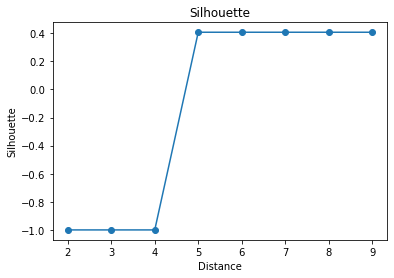

D'après l'indice de silhouette, nb clusters = 13 , nb feuilles =  20  runtime =  0.000997304916381836 s 



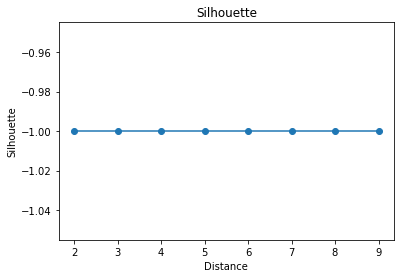

D'après l'indice de silhouette, nb clusters = 2 , nb feuilles =  2  runtime =  0.0 s 



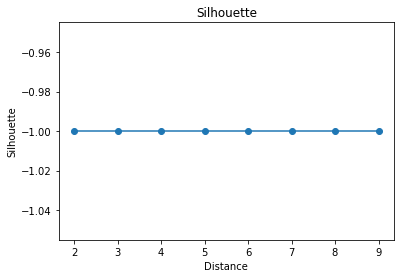

D'après l'indice de silhouette, nb clusters = 2 , nb feuilles =  2  runtime =  0.0 s 



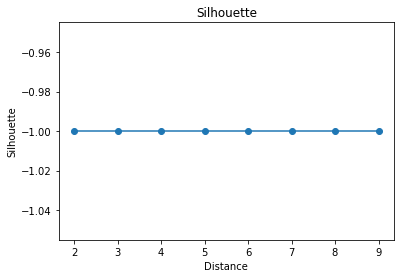

D'après l'indice de silhouette, nb clusters = 8 , nb feuilles =  8  runtime =  0.0 s 



In [26]:
for data in layers:
       list, k_max, leaves_max, runtime = cl.silhouette(data, 2,10)

       print("D'après l'indice de silhouette, nb clusters =", k_max ,", nb feuilles = ", leaves_max , 
              " runtime = ", runtime ,"s \n")

In [30]:
print(list_equal)
print (len(matrix))
cl.clustering(layers, 2, 10, 0.5)

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, False, True, False, True, True, True, True, True, True, True]
32
______________________________________dist =  2
[[6, 16, 5, 22, 35, 29, 42, 0, 15, 52, 20, 32, 18, 27, 0, 5, 53, 9, 13, 8, 20, 29, 41, 49, 52, 22, 6, 56, 30, 42, 28, 13, 53, 16, 49, 19], [6, 16, 5, 22, 35, 29, 42, 0, 15, 56, 20, 32, 18, 27, 0, 5, 53, 9, 13, 8, 20, 29, 41, 49, 52, 22, 6, 55, 30, 42, 28, 13, 53, 16, 49, 19], [6, 16, 5, 22, 54, 29, 42, 0, 15, 52, 20, 32, 18, 27, 0, 5, 47, 9, 13, 8, 20, 29, 35, 46, 52, 22, 6, 56, 30, 42, 28, 13, 47, 16, 43, 19], [6, 16, 5, 22, 54, 29, 42, 0, 15, 56, 20, 32, 18, 27, 0, 5, 47, 9, 13, 8, 20, 29, 35, 46, 52, 22, 6, 55, 30, 42, 28, 13, 47, 16, 43, 19], [6, 16, 5, 22, 47, 29, 42, 0, 15, 52, 20, 32, 18, 27, 0, 5, 53, 9, 13, 8, 20, 29, 35, 46, 52, 22, 6, 56, 30, 42, 28, 13, 47, 16, 43, 19], [6, 16, 5, 22, 47, 29, 42, 0, 15, 56, 20, 32, 18, 27, 0, 5, 53, 9, 1

TypeError: 'float' object cannot be interpreted as an integer